## Import Libraries

In [1]:
import os
import urllib.request
import tarfile
import shutil
import pickle
import pathlib
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

### Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each

Here I have taken CIFAR-10 dataset and my 3 custom catgories are - airplanes, ships, cars with 300 images per category

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
path = "cifar-10-python.tar.gz"
urllib.request.urlretrieve(url, path)

('cifar-10-python.tar.gz', <http.client.HTTPMessage at 0x266282cd150>)

In [3]:
with tarfile.open(path) as tar:
    tar.extractall()

## "transport_photos" is the main data directory where 3 catgories would be made - airplanes, cars and ships

In [4]:
data_dir = "transport_photos"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
airplanes_dir = os.path.join(data_dir, "airplanes")
ships_dir = os.path.join(data_dir, "ships")
cars_dir = os.path.join(data_dir, "cars")

In [6]:
for category_dir in [airplanes_dir, ships_dir, cars_dir]:
    if not os.path.exists(category_dir):
        os.makedirs(category_dir)
cifar = "cifar-10-batches-py"

In [7]:
num_images = 300
category_counts = {category: 0 for category in ["airplanes", "ships", "cars"]}

with open(os.path.join(cifar, f'data_batch_1'), 'rb') as file:
    batch_data = pickle.load(file, encoding='bytes')

    for i, label in enumerate(batch_data[b'labels']):
        image_data = batch_data[b'data'][i]
        image = Image.fromarray(image_data.reshape((3, 32, 32)).transpose(1, 2, 0))
        image_filename = f"{100 + i}.png"

        # for airplanes
        if label == 0:
            if category_counts['airplanes'] < num_images:
                image.save(os.path.join(airplanes_dir, image_filename))
                category_counts['airplanes'] += 1
        # for ships
        elif label == 8:
            if category_counts['ships'] < num_images:
                image.save(os.path.join(ships_dir, image_filename))
                category_counts['ships'] += 1
        # for cars
        elif label == 1:
            if category_counts['cars'] < num_images:
                image.save(os.path.join(cars_dir, image_filename))
                category_counts['cars'] += 1
        
        temp_count = 0
        for count in category_counts.values():
            if count >= num_images:
                temp_count += 1
        if temp_count == len(category_counts.values()):
            break

print("Done saving images")

Done saving images


### Step 2. Split this data between 80% training and 20% test

### Step 3. Preprocess the data as you see fit

In [44]:
data_dir = "transport_photos"

data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [45]:
dataset = ImageFolder(data_dir, transform = data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [46]:
print(len(train_dataset))
print(len(test_dataset))

720
180


In [47]:
class_names = dataset.classes
print(class_names)

['airplanes', 'cars', 'ships']


In [48]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


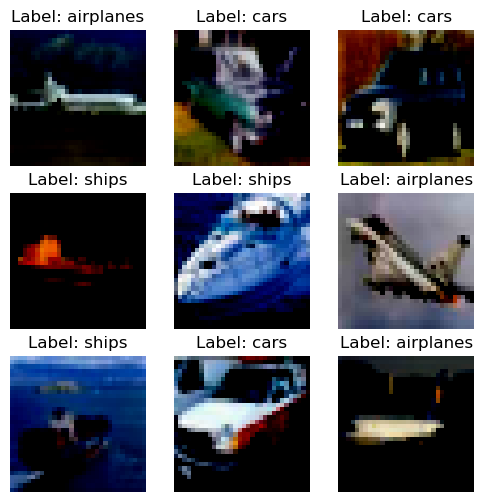

In [49]:
data_iter = iter(train_dataloader)

images, labels = next(data_iter)

plt.figure(figsize=(6, 6))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

In [50]:
for image_batch, labels_batch in train_dataloader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [51]:
print(len(train_dataloader.dataset))
print(train_dataloader.dataset[0][0].shape)
print(train_dataloader.dataset[1][0].shape)

720
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


In [52]:
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


### Step 4. Create a Convolutional Neural Network model to learn about your training set 

In [53]:
class CustomModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (img_height // 8) * (img_width // 8), 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

img_height, img_width = 32, 32
num_classes = 3

model = CustomModel(num_classes, img_height, img_width)
print(model)

CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [54]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

num_epochs = 3
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/3, Loss: 1.0231, Accuracy: 0.4917
Epoch 2/3, Loss: 0.8388, Accuracy: 0.6375
Epoch 3/3, Loss: 0.7478, Accuracy: 0.6764


**With Data Augmentation**

In [55]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

num_epochs = 3
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/3, Loss: 0.7003, Accuracy: 0.6861
Epoch 2/3, Loss: 0.6211, Accuracy: 0.7292
Epoch 3/3, Loss: 0.5383, Accuracy: 0.7792


### Step 5. Make predictions on the test data and compare them to the expected categories

In [56]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 67.78%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


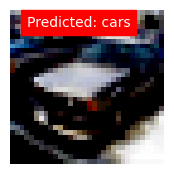

In [57]:
model.eval()

images, labels = next(iter(test_dataloader))

with torch.no_grad():
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(2, 2))
predicted_class_name = class_names[predicted[3].item()]
image = images[3].numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.axis('off')
plt.text(3, 3, f'Predicted: {predicted_class_name}', fontsize=10, color='white', backgroundcolor='red')
plt.show()

### Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [58]:
googlenet_model = models.googlenet(pretrained=True)

num_features = googlenet_model.fc.in_features
googlenet_model.fc = nn.Linear(num_features, num_classes)

print(googlenet_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [59]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc = calculate_accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

optimizer_googlenet = optim.Adam(googlenet_model.parameters())
criterion_googlenet = nn.CrossEntropyLoss()

num_epochs = 5
train_model(googlenet_model, train_dataloader, criterion_googlenet, optimizer_googlenet, num_epochs)

Epoch 1/5, Loss: 0.8788, Accuracy: 0.5778
Epoch 2/5, Loss: 0.4579, Accuracy: 0.8306
Epoch 3/5, Loss: 0.1324, Accuracy: 0.9583
Epoch 4/5, Loss: 0.0597, Accuracy: 0.9819
Epoch 5/5, Loss: 0.0435, Accuracy: 0.9931


### Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [60]:
googlenet_model.eval()
correct_googlenet = 0
total_googlenet = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = googlenet_model(images)
        _, predicted_googlenet = torch.max(outputs.data, 1)
        total_googlenet += labels.size(0)
        correct_googlenet += (predicted_googlenet == labels).sum().item()

accuracy_googlenet = correct_googlenet / total_googlenet
print(f'GoogLeNet Test Accuracy: {accuracy_googlenet * 100:.2f}%')

GoogLeNet Test Accuracy: 81.67%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


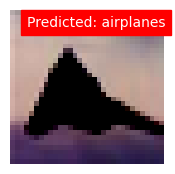

In [62]:
googlenet_model.eval()

images, labels = next(iter(test_dataloader))

with torch.no_grad():
    outputs = googlenet_model(images)

_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(2, 2))
predicted_class_name = class_names[predicted[0].item()]
image = images[0].numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.axis('off')
plt.text(3, 3, f'Predicted: {predicted_class_name}', fontsize=10, color='white', backgroundcolor='red')
plt.show()

### Conclusion: GoogLeNet Test Accuracy: 81.67% | Convolutional Neural Network model Test Accuracy: 67.78%

GoogLeNet Test Accuracy comes higher than Convolutional Neural Network model Test Accuracy.

## Github Repository Link

https://github.com/daminivichare66/CIFAR10_Classification_CNN